#Market Risk and VaR Estimation Methodologies with Python

### About this notebook
Documention prepared by **Jesus Perez Colino**.
Version 0.1, Released 25/11/2013, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.
- **Summary**: This notebook is a quick summary of how to implement the different estimation methods for the VaR in Python.
- **Reproducibility conditions**: the content in this technical note can be reproduce in your computer under the following versions of the Python's packages: 

In [27]:
%matplotlib inline

import numpy as np
import scipy as sci
import scipy.stats as scs
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from pandas.io.data import DataReader, DataFrame

rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
plt.style.use('ggplot')

from sys import version
print ' Reproducibility conditions for the VaR estimation'.center(80, '-')
print 'Python version:     ' + version
print 'Numpy version:      ' + np.__version__
print 'Scipy version:      ' + sci.__version__
print 'Pandas version:     ' + pd.__version__
print 'Matplotlib ver:     ' + mpl.__version__

print '-'*80

--------------- Reproducibility conditions for the VaR estimation---------------
Python version:     2.7.10 |Anaconda 2.3.0 (x86_64)| (default, May 28 2015, 17:04:42) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Numpy version:      1.9.2
Scipy version:      0.15.1
Pandas version:     0.16.2
Matplotlib ver:     1.4.3
--------------------------------------------------------------------------------


## Introduction: Stock market returns and volatility

Let's start downloading some stock market data for Google (stock market ticker is `GOOG`) from the year 2010 and plot its evolution over time.

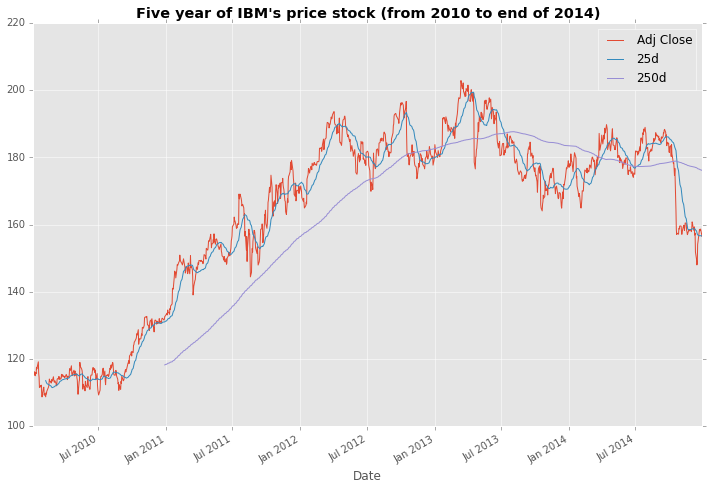

In [28]:

IBM = DataReader(name = "IBM", 
                  data_source = "yahoo", 
                  start = datetime(2010, 1, 1), 
                  end = datetime(2014, 12, 31))

IBM['25d'] = pd.rolling_mean(IBM['Adj Close'], 
                              window=25)

IBM['250d'] = pd.rolling_mean(IBM['Adj Close'], 
                               window=250)

IBM[['Adj Close', '25d', '250d']].plot()
plt.title("Five year of IBM's price stock (from 2010 to end of 2014)", 
          weight='bold');


Usually, in financial modelling, and specifically in risk analysis, we are more interested in the relative daily changes than in the absolute value of the stock, so plot the relative daily returns over the Google price time series. 

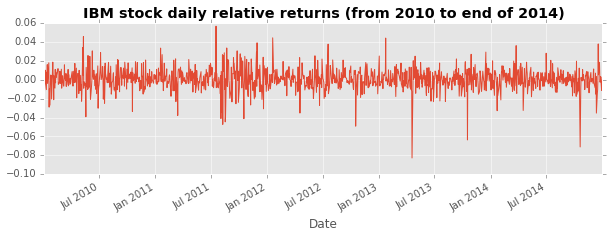

In [30]:
fig = plt.figure()
fig.set_size_inches(10,3)
IBM["Adj Close"].pct_change().plot()
plt.title(u"IBM stock daily relative returns (from 2010 to end of 2014)", 
          weight='bold');

In [31]:
IBM["Adj Close"].pct_change().describe()

count    1257.000000
mean        0.000297
std         0.011683
min        -0.082790
25%        -0.005500
50%         0.000213
75%         0.006480
max         0.056652
Name: Adj Close, dtype: float64

IBM standard deviation over daily relative returns:  0.0116829105309


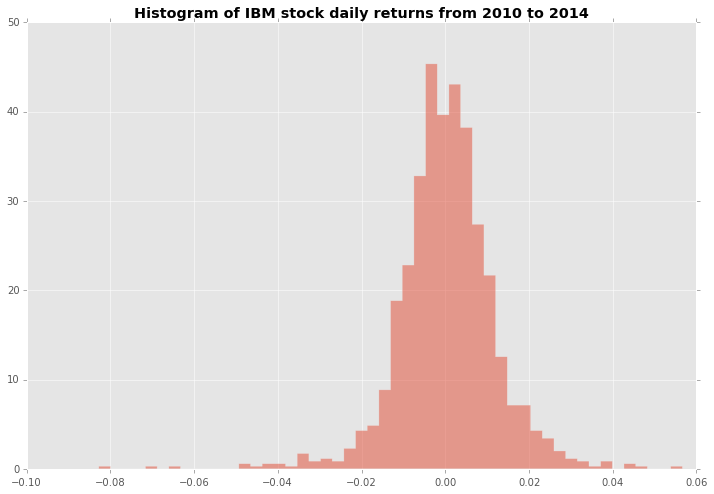

In [32]:
(IBM["Adj Close"]
 .pct_change()
 .hist(bins=50, normed=True, histtype='stepfilled', alpha=0.5))

plt.title(u"Histogram of IBM stock daily returns from 2010 to 2014", 
          weight='bold')

print 'IBM standard deviation over daily relative returns: ', IBM["Adj Close"].pct_change().std()

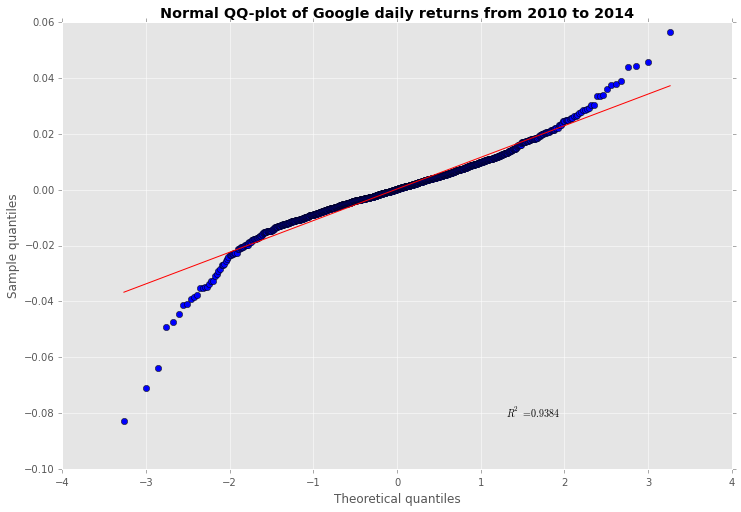

In [34]:
Q = IBM["Adj Close"].pct_change().dropna().as_matrix()
sci.stats.probplot(Q, 
                     dist = sci.stats.norm, 
                     plot = plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Google daily returns from 2010 to 2014", 
          weight="bold")
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles');

In [35]:
def normality_tests(array):
    ''' Tests for normality distribution of given data set'''
    print "Skew of data set %14.3f" % scs.skew(array)
    print "Skew test p-value %14.3f" % scs.skewtest(array)[1]
    print "Kurt of data set %14.3f" % scs.kurtosis(array)
    print "Kurt test p-value %14.3f" % scs.kurtosistest(array)[1]
    print "Norm test p-value %14.3f" % scs.normaltest(array)[1]
    
returns = np.array(IBM["Adj Close"].pct_change().dropna())
normality_tests(returns.flatten())

Skew of data set         -0.570
Skew test p-value          0.000
Kurt of data set          5.505
Kurt test p-value          0.000
Norm test p-value          0.000


The test values indicate that the log returns are not normally distributed — i.e., they
show p-values below of 0.05 , therefore the normality assumption is rejected

Let's see whether the daily returns are better represented by a Student-t distribution.

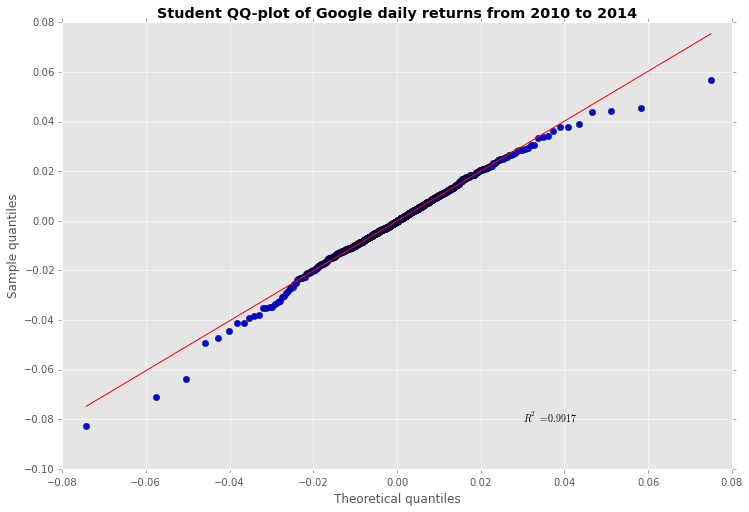

In [36]:
tdf, tmean, tsigma = sci.stats.t.fit(Q)
sci.stats.probplot(Q, 
                     dist = sci.stats.t, 
                     sparams = (tdf, tmean, tsigma), 
                     plot = plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Google daily returns from 2010 to 2014", 
          weight="bold")
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles');

Student's t distribution does seem to fit better (look in particular at the tails of the distribution).

# Value at Risk: Definition


## Value at Risk using the Historical Method

**Historical simulation** is one popular way of estimating VaR. It involves using past data as a guide to what will happen in the future. 

Suppose that we want to calculate VaR for a portfolio using a one-day time horizon, a 99% confidence level, and 501 days of data. (The time horizon and confidence level are those typically used for a market risk VaR calculation; 501 is a popular choice for the number of days of data used because, as we shall see, it leads to 500 scenarios being created.) The first step is to identify the market variables affecting the portfolio. These will typically be interest rates, equity prices, commodity prices, and so on. All prices are measured in the same domestic currency. For example, one market variable for a German bank is likely to be the S&P 500 measured in euros.

The estimate of VaR is the loss when we are at this 99th percentile point. We are 99% certain that we will not take a loss greater than the VaR estimate if the changes in market variables in the last 501 days are representative of what will happen between today and tomorrow.

Here we calculate **empirical quantiles** from a histogram of daily returns. Let's do that for the returns of IBM (stock market ticker `IBM`) over 2013-2014 (503 market sessions).

Statistis Summary of IBM relative returns
count    503.000000
mean      -0.000252
std        0.011249
min       -0.082790
25%       -0.005839
50%       -0.000324
75%        0.006123
max        0.044064
Name: Adj Close, dtype: float64


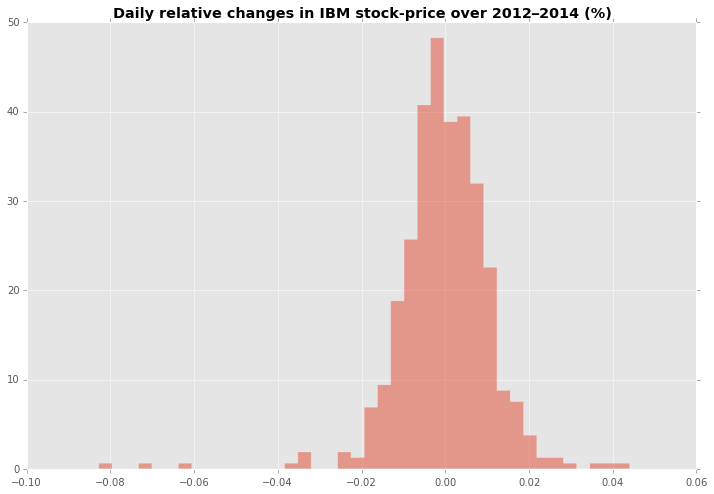

In [38]:
start = datetime(2013, 1, 1)
end   = datetime(2014, 12, 31)
stock = DataReader("IBM", "yahoo", start, end)
returns = stock["Adj Close"].pct_change().dropna()
print 'Statistis Summary of IBM relative returns'
print returns.describe()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = sci.stats.t.fit(returns.as_matrix())
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.title(u"Daily relative changes in IBM stock-price over 2012–2014 (%)", weight='bold');

In [39]:
print 'Quantile 95%:',returns.quantile(0.05)
print 'Quantile 99%:',returns.quantile(0.01)

Quantile 95%: -0.0151905645956
Quantile 99%: -0.0327920535528


The `0.05` empirical quantile of daily returns is at `-0.015`. That means that with `95%` confidence, our worst daily loss will not exceed `1.5%`. If we have a 1M USD investment, our one-day 5% VaR is `0.015` * 1M USD = `15,000` USD. Simillarly, with `99%` confidence, our worst daily loss will not exceed `3.2%`, or our lost will not bigger than `32,000` USD in one single day.

## Value at Risk using the Variance-Covariance method

The main alternative to historical simulation is the variance-covariance method also know as the model-building approach. 

A second methodology is to calculate analytic quantiles by curve fitting to historical data. Here, we use Student's t distribution (we checked above that it represents daily returns relatively well).

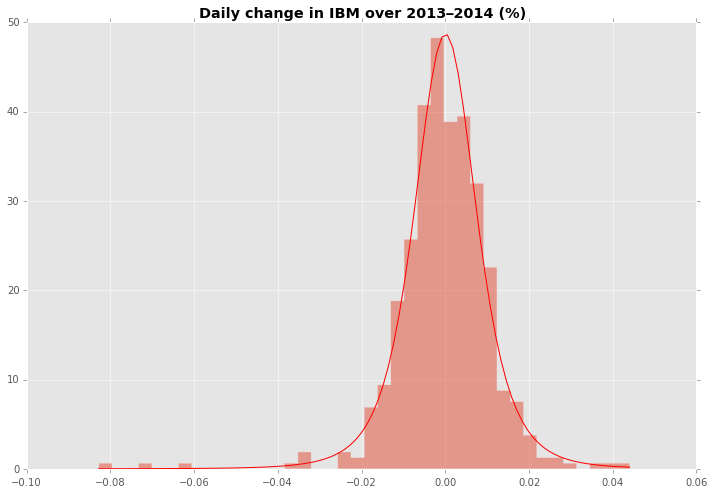

In [41]:
support = np.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, sci.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in IBM over 2013–2014 (%)", weight='bold');

In [43]:
print 'Quantile 95%:',sci.stats.norm.ppf(0.05, mean, sigma)
print 'Quantile 99%:',sci.stats.norm.ppf(0.01, mean, sigma)

Quantile 95%: -0.018754684074
Quantile 99%: -0.0264208261378


Our analytic 0.05 quantile is at -0.01875, so with 95% confidence, our worst daily loss will not exceed 1.875%. For a 1M USD investment, one-day Value at Risk is 0.01875 * 1M USD = 18.75k USD, and 26.42k USD with a 99% of confidence.

## Value at Risk using the Monte Carlo method

As an alternative to the procedure described so far, the variance-covariance approach can be implemented using Monte Carlo simulation to generate the probability distribution of the relative returns of the risk factor.

The idea behind this third methodology is based in simulation of many trials or samples of prices evolutions on time, calculating stock/portfolio loss for each trial. Use the aggregated trial data to establish a profile of the stock/porfolio's risk characteristics.

The basic hypothesis behind this method is the idea that stock market evolution can be simulated by geometric Brownian motion (this is a rough hypothesis; see the literature on stochastic methods in finance for more sophisticated, and more realistic, models, such as jump-diffusion).

Start by defining some parameters of the geometric Brownian motion.

In [44]:
days = 300   # time horizon
dt = 1/float(days)

mu = returns.mean()
sigma = returns.std()

startprice = IBM['Adj Close'][-1]

This function simulates one stock market evolution, and returns the price evolution as an array. It simulates geometric Brownian motion using random numbers drawn from a normal distribution (see accompanying slides).

In [45]:
def random_walk(startprice):
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc = mu * dt, 
                                    scale = sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

Let's simulate 30 random walks, starting from an initial stock price of 10€, for a duration of 300 days.

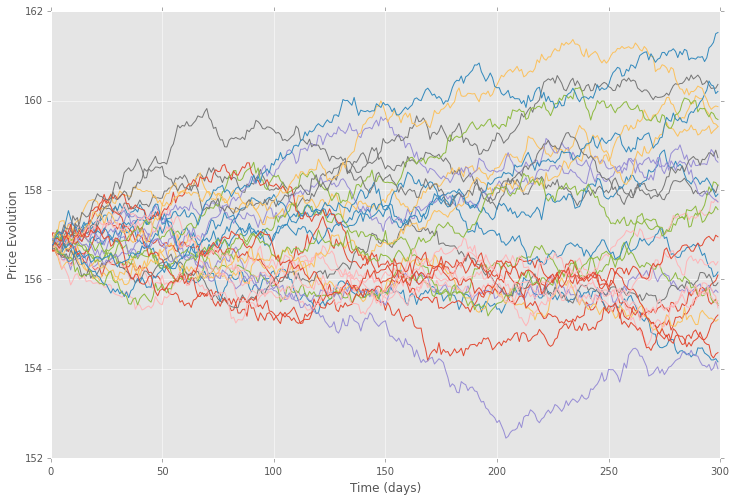

In [46]:
for run in range(30):
    plt.plot(random_walk(startprice))
plt.xlabel("Time (days)")
plt.ylabel("Price Evolution");

Now let's run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation. This will take a little time to run (return variable `runs` if you want faster, but less representative, results).

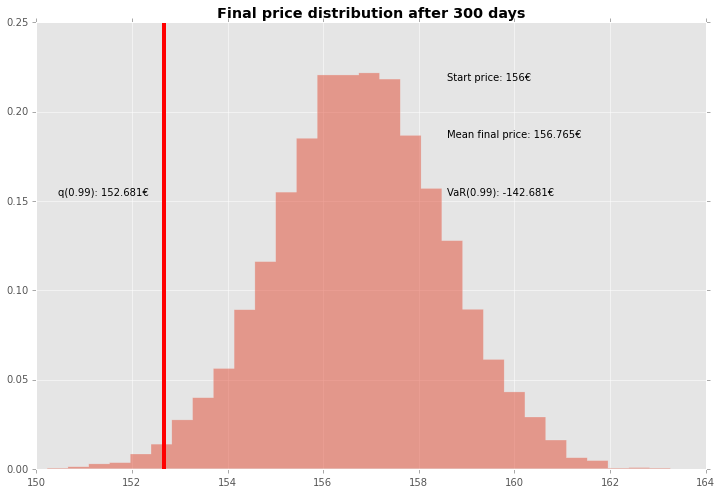

In [47]:
runs = 10000
simulations = np.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(startprice)[days-1]
q = np.percentile(simulations, 1)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, u"Start price: 156€")
plt.figtext(0.6, 0.7, u"Mean final price: %.3f€" % simulations.mean())
plt.figtext(0.6, 0.6, u"VaR(0.99): %.3f€" % (10 - q,))
plt.figtext(0.15, 0.6, u"q(0.99): %.3f€" % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u"Final price distribution after %s days" % days, weight='bold');

## Correlation between stocks

In [5]:
start = datetime(2005, 1, 1)
end   = datetime(2015, 1, 1)
CAC = DataReader("^FCHI", "yahoo", start, end)
DAX = DataReader("^GDAXI", "yahoo", start, end)
HSI = DataReader("^HSI", "yahoo", start, end)
AORD = DataReader("^DJI", "yahoo", start, end)

df = DataFrame({ 'CAC': CAC["Close"].pct_change(),
                 'DAX': DAX["Close"].pct_change(),
                 'HSI': HSI["Close"].pct_change(),
                 'DJI': AORD["Close"].pct_change() })
dfna = df.dropna()

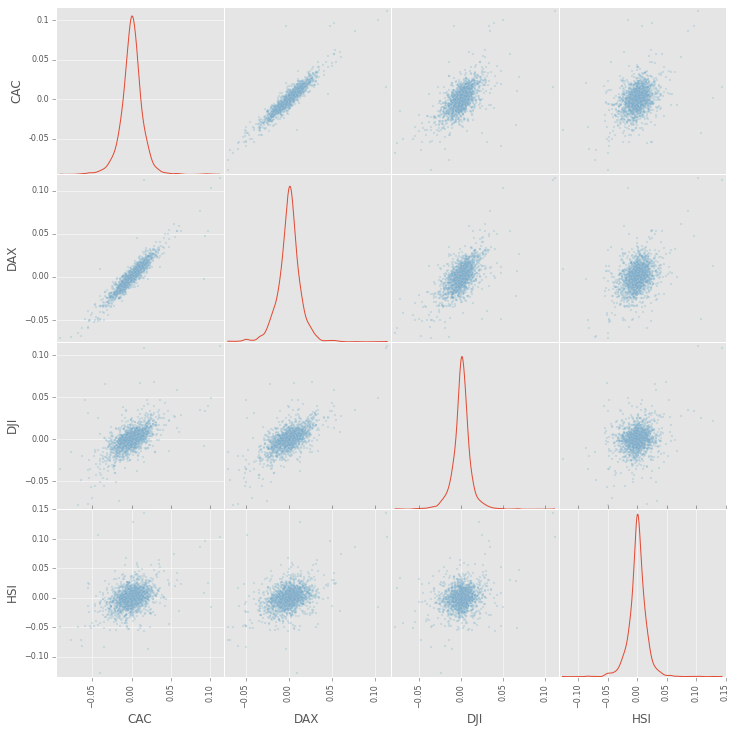

In [14]:
pd.scatter_matrix(dfna, alpha=0.2, figsize=(12, 12),  diagonal='kde');

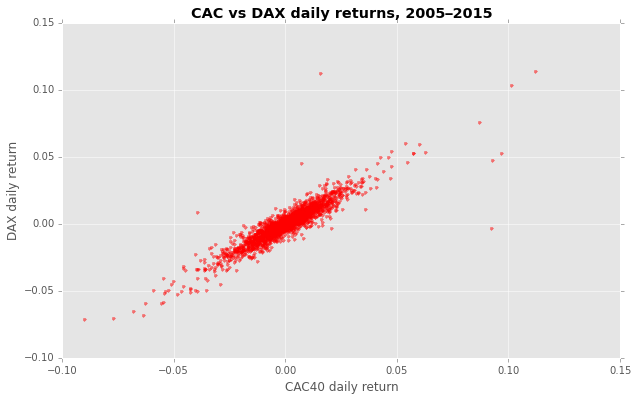

In [6]:
plt.plot(dfna["CAC"], dfna["DAX"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DAX daily return")
plt.title(u"CAC vs DAX daily returns, 2005–2015", weight='bold');

In [217]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DAX"])

(0.91978706267326948, 0.0)

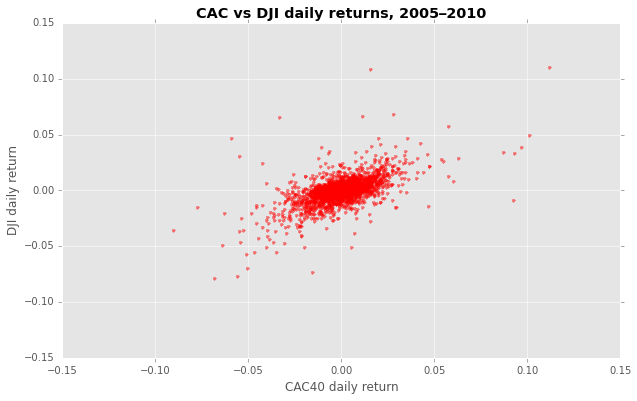

In [219]:
plt.plot(dfna["CAC"], dfna["DJI"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DJI daily return")
# ensure square aspect ratio
plt.axes().set_xlim(-0.15, 0.15)
plt.axes().set_ylim(-0.15, 0.15)
plt.title(u"CAC vs DJI daily returns, 2005–2010", weight='bold');

In [220]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DJI"])

(0.61071367628752282, 6.876663069737151e-248)

CAC t fit: mean=0.000394429241528, scale=0.00946577887963, df=3.29037745725


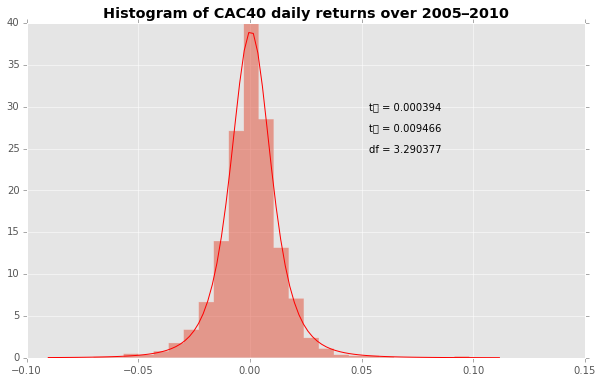

In [221]:
returns = dfna["CAC"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = np.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("CAC t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, u"tσ = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of CAC40 daily returns over 2005–2010", weight='bold');

DAX t fit: mean=0.00073986478715, scale=0.00880772772443, df=3.05298676457


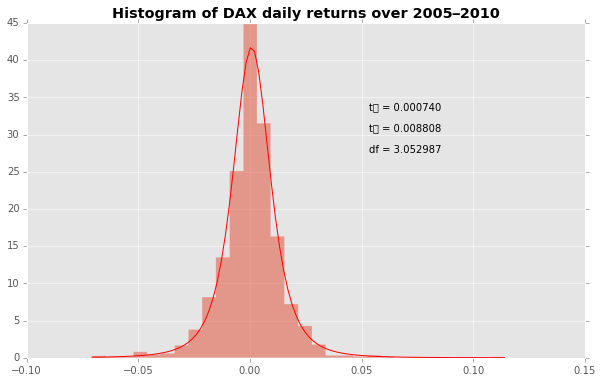

In [222]:
returns = dfna["DAX"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = np.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("DAX t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = %3f" % tmean)
plt.figtext(0.6, 0.65, u"tσ = %3f" % tsigma)
plt.figtext(0.6, 0.6, u"df = %3f" % tdf)
plt.title(u"Histogram of DAX daily returns over 2005–2010", weight='bold');

Let's simulate random joint stock returns from a joint distribution of fitted-CAC and fitted-DAX according to the distribution parameters estimated above, and plot the results. We need these simulated joint returns to do a Monte Carlo VaR analysis of a stock portfolio composed of CAC and DAX stock.

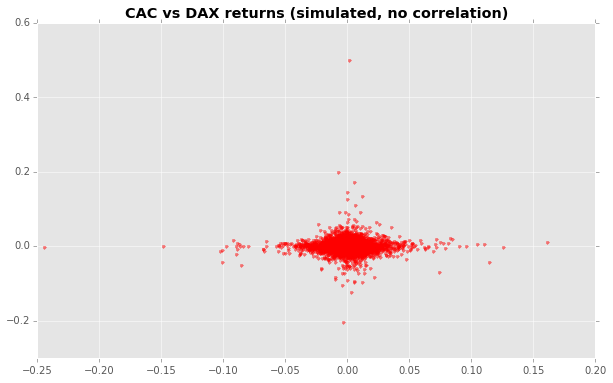

In [223]:
runs = 5000
fittedCAC = np.zeros(runs, float)
fittedDAX = np.zeros(runs, float)
for i in range(runs):
    fittedCAC[i] = scipy.stats.t.rvs(loc=0.000478137351981, 
                                     scale=0.00898201242824, 
                                     df=2.75557323986)
    fittedDAX[i] = scipy.stats.t.rvs(loc=0.000847802944791, 
                                     scale=0.00878082895409, 
                                     df=2.71766905436)
plt.plot(fittedCAC, fittedDAX, 'r.', alpha=0.5)
plt.title(u"CAC vs DAX returns (simulated, no correlation)", weight='bold');